<a href="https://colab.research.google.com/github/pursh2002/Machine-learning-with-Siraj-Raval-sept-2019..-Dr-Purshottam/blob/master/Pneumonia_detection_Kaggle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'pursh2002'
os.environ['KAGGLE_KEY'] = 'xxxxxxx'

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 98% 1.13G/1.15G [00:21<00:00, 43.7MB/s]
100% 1.15G/1.15G [00:21<00:00, 58.0MB/s]


In [0]:
#!unzip chest-xray-pneumonia.zip
#!unzip chest_xray.zip

In [0]:
ls

chest_xray/  chest-xray-pneumonia.zip  chest_xray.zip  __MACOSX/  sample_data/


In [0]:
ls chest_xray/train/

NORMAL/  PNEUMONIA/


In [0]:
ls chest_xray/test

NORMAL/  PNEUMONIA/


**Import** 

In [0]:
import keras
import os
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
path_train = "/content/chest_xray/train"
path_test = "/content/chest_xray/test"
path_val = "/content/chest_xray/val"

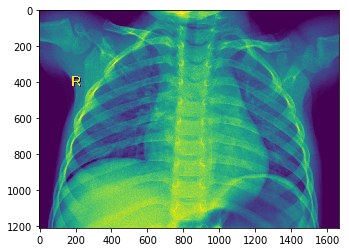

In [132]:
img = mpimg.imread(path_train + '/NORMAL/IM-0215-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1


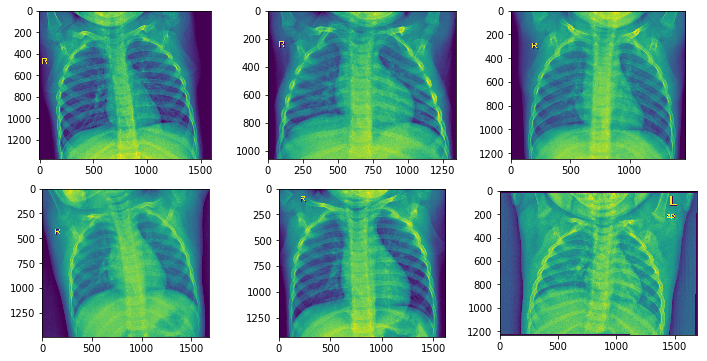

In [134]:
plot_images(path_train + '/NORMAL')

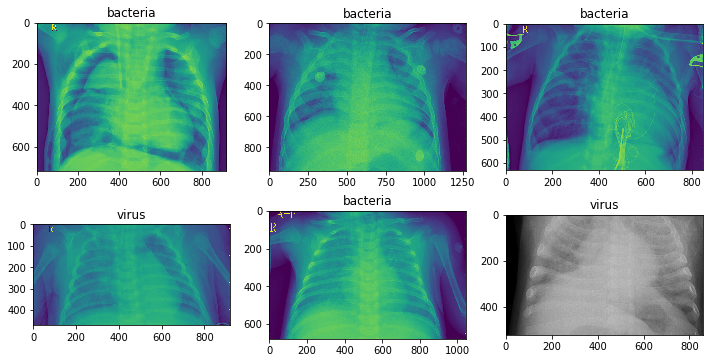

In [135]:
plot_images(path_train + '/PNEUMONIA', labeled=True)

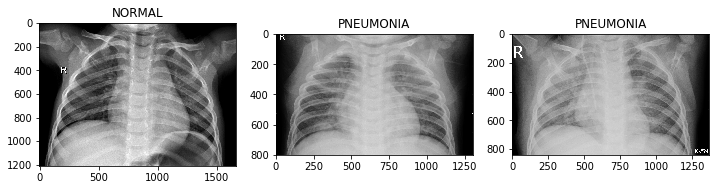

In [136]:
# Normal 
img_normal = plt.imread(path_train + '/NORMAL/IM-0215-0001.jpeg')
# Bacterial
img_penumonia_bacteria = plt.imread(path_train + '/PNEUMONIA/person1513_bacteria_3962.jpeg')
# Viral
img_penumonia_virus = plt.imread(path_train + '/PNEUMONIA/person620_virus_1191.jpeg')

# Plot Configuration
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')
plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')
plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')


In [0]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

In [138]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-09-25 11:02:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  48.6MB/s    in 1.7s    

2019-09-25 11:02:22 (48.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150,3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [141]:
last_layer = pre_trained_model.get_layer('mixed7')
print ('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [0]:
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

In [143]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'binary'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    path_val,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [144]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/2
100/100 - 72s - loss: nan - acc: 0.7513 - val_loss: nan - val_acc: 0.5000
Epoch 2/2
100/100 - 62s - loss: nan - acc: 0.7256 - val_loss: nan - val_acc: 0.5000


In [0]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [147]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/5
100/100 - 74s - loss: nan - acc: 0.7391 - val_loss: nan - val_acc: 0.5000
Epoch 2/5
100/100 - 61s - loss: nan - acc: 0.7453 - val_loss: nan - val_acc: 0.5000
Epoch 3/5
100/100 - 61s - loss: nan - acc: 0.7494 - val_loss: nan - val_acc: 0.5000
Epoch 4/5
100/100 - 62s - loss: nan - acc: 0.7281 - val_loss: nan - val_acc: 0.5000
Epoch 5/5
100/100 - 61s - loss: nan - acc: 0.7534 - val_loss: nan - val_acc: 0.5000


Text(0.5, 1.0, 'Training and validation loss')

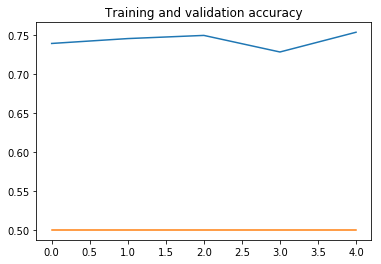

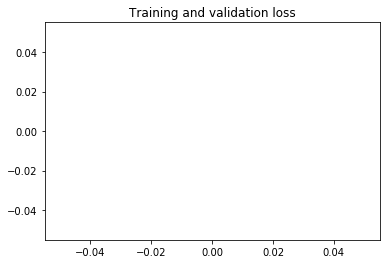

In [148]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [149]:
from sklearn.metrics import classification_report


yhat = model.predict_generator(test_generator,
                                 steps = len(test_generator),
                                 verbose = 2)  
mask = yhat > 0.5
yhat[mask] = 1
yhat[~mask] = 0

y = test_generator.classes

target_names = [positive_class_folder_name, negative_class_folder_name]
print(classification_report(y, yhat, target_names = target_names))

624/624 - 18s
              precision    recall  f1-score   support

   PNEUMONIA       0.38      1.00      0.55       234
      NORMAL       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



In [150]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

624/624 [==============================] - 22s 36ms/step - loss: nan - acc: 0.3750
Loss: nan
Accuracy: 0.375


In [127]:
y_pred_batches = []
y_true_batches = []
y_img_batches =[]

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),

In [0]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

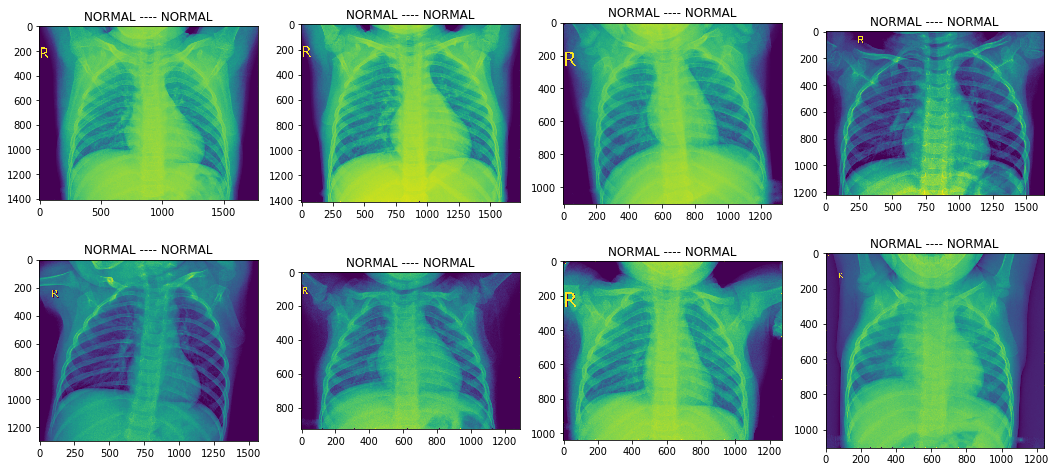

In [129]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')


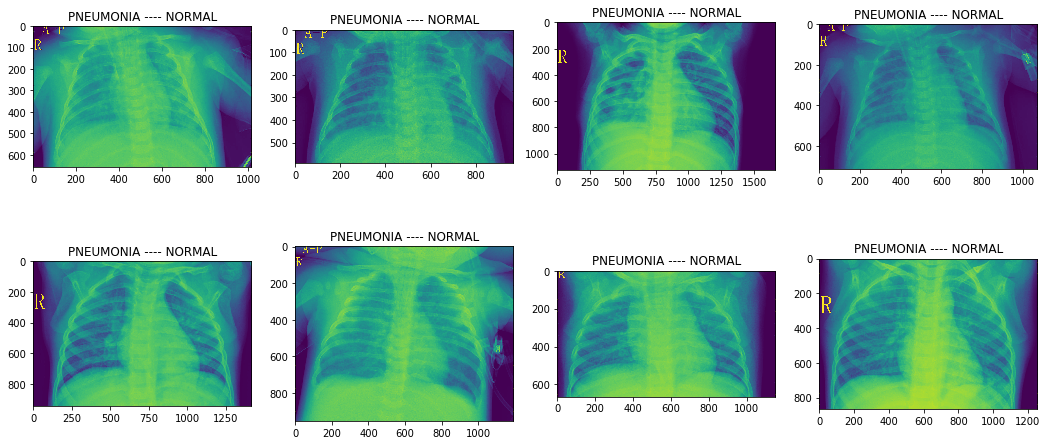

In [130]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')